# Relevance of microphysical processes

**Idea:** Plot the mean of the frozen and liquid mass changing processes against their occurrence. The higher they are on the diagonal, the more important they should be.    

**Steps to get there:**
- Sum up all the processes of the frozen and liquid mass which overlap between single hydrometeors. 
- Then compute the mean of the processes mass change.
- Compute the total number of cases
- Compute the total change in each case
- Compute in how many of the total number of cases a processes makes at least more than 1% mass difference.

Uses the class "Process" to get statistics etc.

In [14]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import ListedColormap
import seaborn as sns

import sys
sys.path.append('../required_modules/')
from process_class import Process

## 1. Data

In [6]:
# get data
fig_path='../figures/'
data_path = '/data/'
ds_pn_pd_mpc = xr.open_dataset(data_path+'processed/nc_files_revisions/df_all_tends_mpc_pn_and_pd_v1.nc')
ds_pn_pd_all = xr.open_dataset(data_path+'processed/nc_files_revisions/df_all_tends_all_pn_and_pd_v1.nc')

Numbers of days per data set

In [7]:
# compute total number of timesteps in the dataset
# 1 timestep in output = 9 seconds
tsinminutes = 60/9
print('pn mpc days: {:.2f}'.format( ds_pn_pd_mpc.sel(time=ds_pn_pd_mpc['time.month'].isin([11,12,1,2])).time.shape[0]/tsinminutes/60/24))
print('pd mpc days: {:.2f}'.format( ds_pn_pd_mpc.sel(time=ds_pn_pd_mpc['time.month'].isin([5,6,7,8])).time.shape[0]/tsinminutes/60/24))
print('pn and pd mpc days: {:.2f}'.format( ds_pn_pd_mpc.time.shape[0]/tsinminutes/60/24))

print('pn all days: {:.2f}'.format( ds_pn_pd_all.sel(time=ds_pn_pd_all['time.month'].isin([11,12,1,2])).time.shape[0]/tsinminutes/60/24))
print('pd all days: {:.2f}'.format( ds_pn_pd_all.sel(time=ds_pn_pd_all['time.month'].isin([5,6,7,8])).time.shape[0]/tsinminutes/60/24))
print('pn and pd all days: {:.2f}'.format( ds_pn_pd_all.time.shape[0]/tsinminutes/60/24))

pn mpc days: 14.10
pd mpc days: 9.69
pn and pd mpc days: 23.79


pn all days: 26.30
pd all days: 37.87
pn and pd all days: 64.17


Mixed phase clouds processes get an instance each

In [8]:
Evaporation_mpc = Process(ds_pn_pd_mpc.evaporation_li)
WBF = Process(ds_pn_pd_mpc.wbf)
Deposition_mpc = Process(ds_pn_pd_mpc.deposition_fr)
Sublimation_mpc = Process(ds_pn_pd_mpc.sublimation_fr)
Rain_freezing = Process(ds_pn_pd_mpc.r_freeze_fr)
Riming = Process(ds_pn_pd_mpc.rime_fr)
Condensation_mpc = Process(ds_pn_pd_mpc.condensation_li)
Homhet_mpc = Process(ds_pn_pd_mpc.homhet_fr)
CCN_act_mpc = Process(ds_pn_pd_mpc.ccn_act_li)
Melting = Process(ds_pn_pd_mpc.melt_fr)
Fr_eva = Process(ds_pn_pd_mpc.fr_eva_fr)
C_homfreezing = Process(ds_pn_pd_mpc.c_homfr_li)

Now only liquid and only frozen clouds are selected and then only frozen - vapour and liquid - vapour interactions are computed.

In [9]:
# create smaller dataset 
ds_pn_pd_all_sel = ds_pn_pd_all[['evaporation_li', 'condensation_li', 'sublimation_fr', 'deposition_fr', 
                                'homhet_fr', 'ccn_act_li',
                                'frozen_mass', 'liquid_mass']]
ds_pn_pd_all_sel

<xarray.Dataset>
Dimensions:          (time: 616006, height_2: 39)
Coordinates:
  * time             (time) datetime64[ns] 2021-05-02T14:04:12 ... 2022-02-28...
  * height_2         (height_2) float64 2.537e+03 2.447e+03 ... 44.98 20.2
Data variables:
    evaporation_li   (time, height_2) float64 ...
    condensation_li  (time, height_2) float64 ...
    sublimation_fr   (time, height_2) float64 ...
    deposition_fr    (time, height_2) float64 ...
    homhet_fr        (time, height_2) float64 ...
    ccn_act_li       (time, height_2) float64 ...
    frozen_mass      (time, height_2) float64 ...
    liquid_mass      (time, height_2) float64 ...

In [10]:
Evaporation_li = Process(ds_pn_pd_all_sel.evaporation_li)
Condensation_li = Process(ds_pn_pd_all_sel.condensation_li)
Deposition_fr = Process(ds_pn_pd_all_sel.deposition_fr)
Sublimation_fr = Process(ds_pn_pd_all_sel.sublimation_fr)
Homhet_fr = Process(ds_pn_pd_all_sel.homhet_fr)
CCN_act_li = Process(ds_pn_pd_all_sel.ccn_act_li)

Create selection of processes and their names for plotting

In [11]:
proc_class_list_mpc = [Evaporation_mpc, Condensation_mpc, CCN_act_mpc, 
                       Deposition_mpc, Sublimation_mpc,
                        Homhet_mpc, Fr_eva, WBF, Rain_freezing, Riming, Melting] #, C_homfreezing]
proc_class_list_nompc = [Evaporation_li, Condensation_li, CCN_act_li, Deposition_fr, Sublimation_fr]

proc_name_list = ["Evaporation", "Condensation", "CCN act.", "Deposition", 
                   "Sublimation", "Hom. het. nuc.", 
                  "Frozen evap.", "WBF", "Rain freezing", 
                  "Riming", "Melting" ] 
#, "Droplet hom. fr."] so seldom that we can ignore it

for process in proc_class_list_mpc:
    process.get_perc(frozen_mass=ds_pn_pd_mpc.frozen_mass, liquid_mass=ds_pn_pd_mpc.liquid_mass)

cloud_type=['liq', 'liq', 'liq', 'frozen', 'frozen', 'frozen']
for i, process in enumerate(proc_class_list_nompc):
    process.get_perc(frozen_mass=ds_pn_pd_all_sel.frozen_mass,
                      liquid_mass=ds_pn_pd_all_sel.liquid_mass, cloud_type=cloud_type[i])

## Create figure

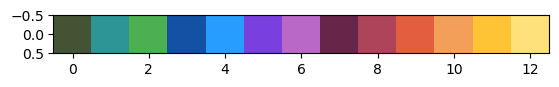

In [12]:
#Define symbols for the processes
symbols = ['o', 'o', 'o', 'x', 'x', 'x', 'x', '*', '*', '*', '*']
# Define the colors for my colormap
colors = ["#435334", "#2D9596","#4CAF50", "#1450A3","#279EFF", "#793FDF", "#BA68C8", 
          "#662549","#AE445A", "#E25E3E","#F39F5A", "#FFC436", "#FFE17B"]

# Create a colormap
cmap = ListedColormap(colors)

# plot this colormap
plt.imshow([range(len(colors))], cmap=cmap)

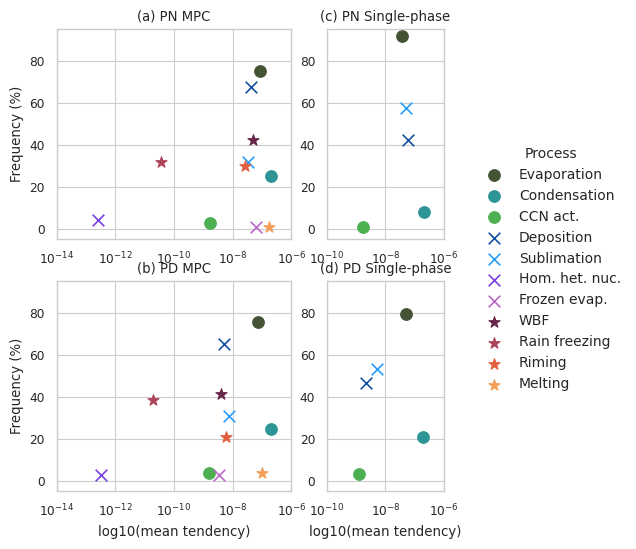

In [13]:
sns.set_style("whitegrid")
sns.set_context("paper")

fig = plt.figure(figsize=(5, 6))
gs = gridspec.GridSpec(2, 2, width_ratios=[2, 1])

axes = [plt.subplot(gs[0,0]), plt.subplot(gs[1,0]), plt.subplot(gs[0,1]), plt.subplot(gs[1,1])]

for i, process in enumerate(proc_class_list_mpc):
    #axes[0,].scatter(process.stats_mean["total"], process.freq["total"], label=proc_name_list[i])
    axes[0].scatter(process.stats_mean["PN"], process.freq["PN"], 
                    label=proc_name_list[i], color=colors[i], marker=symbols[i],
                    s=70)
    axes[1].scatter(process.stats_mean["PD"], process.freq["PD"], 
                    label=proc_name_list[i], color=colors[i], marker=symbols[i],
                    s=70)
for i, process in enumerate(proc_class_list_nompc):
    #axes[0,].scatter(process.stats_mean["total"], process.freq["total"], label=proc_name_list[i])
    axes[2].scatter(process.stats_mean["PN"], process.freq["PN"], 
                    label=proc_name_list[i], color=colors[i], marker=symbols[i],
                    s=70)
    axes[3].scatter(process.stats_mean["PD"], process.freq["PD"], 
                    label=proc_name_list[i], color=colors[i], marker=symbols[i],
                    s=70)

for i in range(4):
         axes[i].set_xscale("log")
         axes[i].set_ylim(-5,95)

axes[0].set_xlim(1e-14,1e-6)
axes[1].set_xlim(1e-14,1e-6)  
axes[2].set_xlim(1e-10,1e-6)
axes[3].set_xlim(1e-10,1e-6)

axes[0].set_title("(a) PN MPC")
axes[1].set_title("(b) PD MPC")
axes[2].set_title("(c) PN Single-phase")
axes[3].set_title("(d) PD Single-phase")

axes[0].set_ylabel("Frequency (%)")
axes[1].set_ylabel("Frequency (%)")

axes[1].set_xlabel("log10(mean tendency)")
axes[3].set_xlabel("log10(mean tendency)")

# add the legend horizontally outside the plot below all subplots. Make two 3 rows with 4 columns each entry containing one label
#axes[0].legend(loc='upper center', bbox_to_anchor=(0.8, -1.4), ncol=4, fontsize=10)
# add the legend vertically outside the plot to the right of all subplots. No border around the legend
axes[0].legend(loc='upper left', bbox_to_anchor=(1.75, 0.5), fontsize=10, 
               title="Process", title_fontsize=10, 
               shadow=False, frameon=False, ncol=1)

plt.savefig(fig_path+"fig02_process_relevance_all_pn_pd_revised.pdf",  format='pdf', bbox_inches='tight')